# Auto Encoder 실습
---

특정 값으로 예측, 특정 클래스로 분류하는 것이 아닌 원본 데이터를 생성하는 AutoEncoder를 만들어 보자

- 흑백 이비지가 10개의 옷 종류로 분류 되어 있는 <span style="color:magenta">FashionMNIST</span> 데이터를 이용해 기본적인 MLP 구조의 AutoEncoder 모델 설계

# Auto Encoder 설계 순서
---

1. import modules
2. Device Check
3. Fashion MNIST Download (데이터 불러오기)
4. Data Check(1)
5. Data Check(2)
6. AutoEncoder 모델 설계
7. Optimizer, Objective Function
8. AE Train Data에 대한 성능 평가 함수
9. Validation Data에 대한 성능 평가 함수
10. AutoEncoder 학습을 실행하면서 Test set의 Reconstruction Error 확인

# 1.import modules

In [1]:
''' 1. import modules '''

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets


# 2.Device Check

In [2]:
''' 2. Device Check'''

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Pytorch version : {torch.__version__}\tDevice : {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 10


Pytorch version : 1.10.1	Device : cuda


# 3.Fashion MNIST Data Download

In [3]:
''' 3. Fashion MNIST Data Download'''

train_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                      train=True,
                                      download=True,
                                      transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                                     train=False,
                                     transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False)


# 4.Data Check(1)

In [4]:
''' 4. Data Check (1) '''

for (X_train, y_train) in train_loader:
    print(f"X_train : {X_train.size()}\ttype : {X_train.type()}")
    print(f"y_train : {y_train.size()}\t\ttype : {y_train.type()}")
    break

X_train : torch.Size([32, 1, 28, 28])	type : torch.FloatTensor
y_train : torch.Size([32])		type : torch.LongTensor


> Data Check(1)  

- `torch.Size([32, 1, 28, 28])` : Mini-Batch - 32개, Channel - Gray(1), 28 x 28 의 데이터
- `torch.Size([32])` : Mini-Batch - 32개

# 5.Data Check(2)

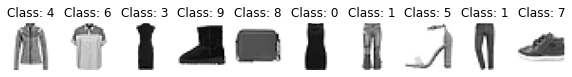

In [5]:
''' 5. Data Check (2) '''

pltSize = 1
plt.figure(figsize=(10*pltSize, pltSize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title(f"Class: {str(y_train[i].item())}")


# 6.AutoEncoder 모델 설계

In [6]:
''' 6. AutoEncoder 모델 설계 '''


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


**새로운 내용 점검**

<span style="color:PINK">**Encoder**</span>

---

```python
self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )
```

- 인코더 정의를 초기자에 수행
- Latent Vector의 크기 (32)에 맞게 끔 순차적으로 설계하고, activation function은 비선형의 `nn.ReLU()` 사용

---

<br><br>

<span style="color:PINK">**Decoder**</span>

---

```python
    self.decoder = nn.Sequential(
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 28 * 28),
    )
```

- 디코더 정의를 초기자에 수행
- Latent Vector로 부터 인코더의 반대 방향으로 설계

---

<br><br>

<span style="color:PINK">**feed forward**</span>

---

```python
def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded
```

- `input` 부터 `encoder`, `decoder`, `output` 까지의 Forward Propagation 설계
- `encoded` : Latent Vector를 생성해 줌
- `decoded` : Latent Vector를 input하여 디코딩 과정 후 output 생성 
---


# 7.Optimizer, Objective Function

In [7]:
''' 7. Optimizer, Objective Function '''

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


# 8.AE Train Data에 대한 성능 평가 함수


In [8]:
''' 8. AE Train Data에 대한 성능 평가 함수 '''

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):   # label을 학습할 필요가 없기 때문에 _로 생략
        image = image.view(-1, 28*28).to(DEVICE)            # 28*28 크기의 1차원 레이어 할당을 위해 Falttern (정의된 장비 활용)
        target = image.view(-1, 28*28).to(DEVICE)           # 28*28 크기의 1차원 레이어 할당을 위해 Falttern (정의된 장비 활용)

        optimizer.zero_grad()               # optimizer Gradient 초기화
        encoded, decoded = model(image)     # AE Input으로 Output 계산
        
        loss = criterion(decoded, target)       # MSE를 기준으로 Loss 계산
        loss.backward()                         # Back Propagation을 통해 계산된 Gradient 값을 각 파라미터 할당
        optimizer.step()                        # 각 파라미터 별 할당된 Gradient 값으로 파라미터 값 업데이트
        
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image),
                len(train_loader.dataset), 100.*batch_idx/len(train_loader),
                loss.item()
            ))

# 9.Validation Data에 대한 성능 평가 함수


In [9]:
''' 9. Validation Data에 대한 성능 평가 함수 '''


def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE)
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image


# 10.AutoEncoder 학습을 실행하면서 Test set의 Reconstruction Error 확인

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.011395
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.010039
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.010964
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.010997
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.009724
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.009063
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.010171
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.009091
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.008210
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.010457

[EPOCH: 1],	Test Loss: 0.0003


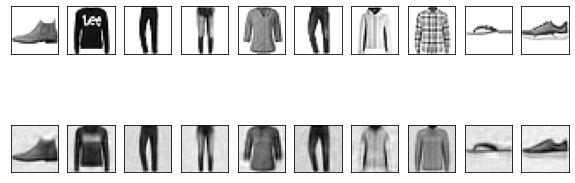

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.009251
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.007566
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.009851
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.008460
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.009172
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.010948
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.008528
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.008639
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.009110
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.010310

[EPOCH: 2],	Test Loss: 0.0003


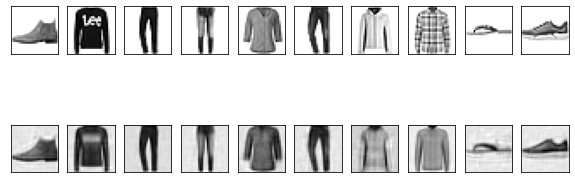

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.008644
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.011963
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.010193
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.008905
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.009730
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.010358
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.011211
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.009640
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.007609
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.010396

[EPOCH: 3],	Test Loss: 0.0003


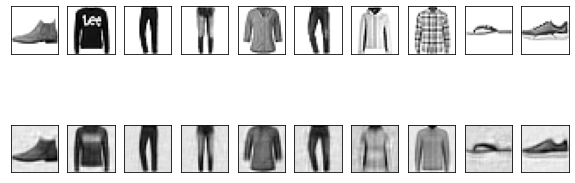

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.008499
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.009770
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.007557
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.007745
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.009611
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.007911
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.008884
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.010358
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.008543
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.008266

[EPOCH: 4],	Test Loss: 0.0003


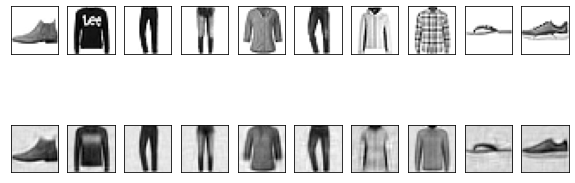

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.008414
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.008032
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.008323
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.010015
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.010113
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.010151
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.010572
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.009481
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.009389
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.009381

[EPOCH: 5],	Test Loss: 0.0003


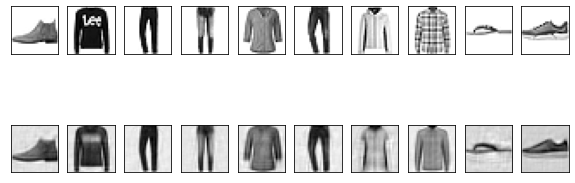

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.009543
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.008035
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.010603
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.007218
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.009024
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.008548
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009012
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.009864
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.008980
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.007907

[EPOCH: 6],	Test Loss: 0.0003


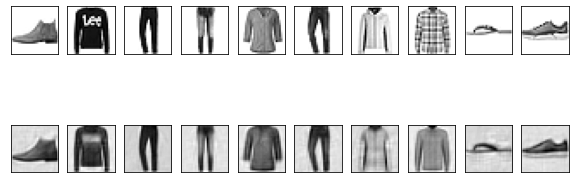

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.008338
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.009365
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.008825
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.008664
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.009219
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.008181
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.010508
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.009864
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.009042
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.007879

[EPOCH: 7],	Test Loss: 0.0003


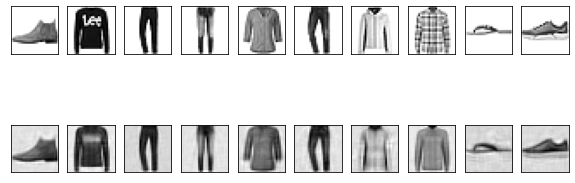

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.010716
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.009973
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.007208
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.009004
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.008306
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.010129
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.008953
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.010218
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.010275
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.008034

[EPOCH: 8],	Test Loss: 0.0003


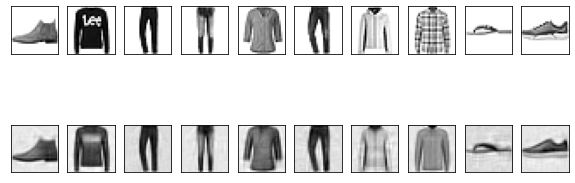

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.012101
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.010173
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.010811
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.007286
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.009367
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.008096
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.010048
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.008774
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.006896
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010800

[EPOCH: 9],	Test Loss: 0.0003


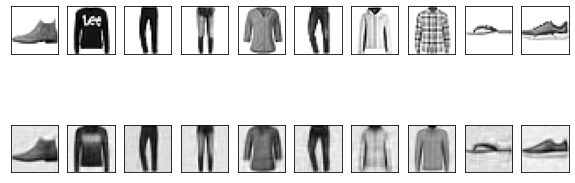

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.009252
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.008533
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.009653
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.007152
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.008499
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.008385
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.009177
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.007721
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.008219
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.009340

[EPOCH: 10],	Test Loss: 0.0003


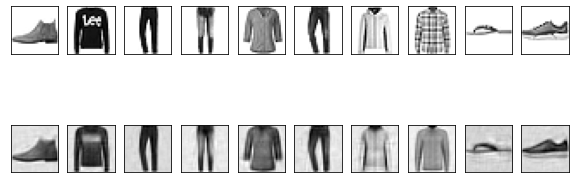

In [13]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    
    print("\n[EPOCH: {}],\tTest Loss: {:.4f}".format(Epoch, test_loss))
    
    f,a = plt.subplots(2, 10, figsize=(10,4))
    
    for i in range(10):
        img = np.reshape(real_image[0][i], (28,28))
        a[0, i].imshow(img, cmap='gray_r')
        a[0, i].set_xticks(())
        a[0, i].set_yticks(())
        
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28,28))
        a[1, i].imshow(img, cmap='gray_r')
        a[1, i].set_xticks(())
        a[1, i].set_yticks(())
        
    plt.show()